In [58]:
import warnings
import pandas as pd 
import numpy as np
import random
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

### 1. Data Visualization and Data Processing

#### 1.1 Descriptive Statistics

In [2]:
# Read in the original train and test dataset
init_test = pd.read_csv('test.csv') 
init_train = pd.read_csv('train.csv')
X_test = init_test.iloc[:,:-2]
y_test = init_test['Activity']

In [5]:
# Check distribution of activity types in train and test set.
# Can see they are balance.
init_train['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [6]:
y_test.value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

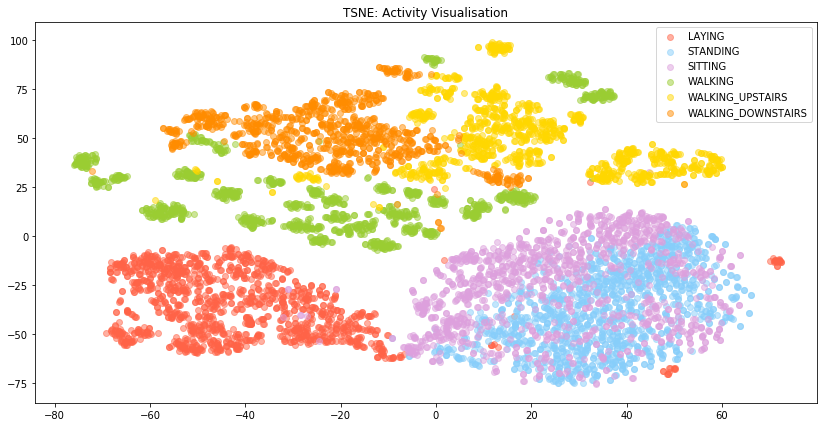

In [12]:
# Implement T-SNE to visualize this high-dimensional dataset.
tsne_data = init_train.iloc[:,:-2].copy()
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)
pca = PCA(n_components=0.9, random_state=0)
tsne_data = pca.fit_transform(tsne_data)
tsne = TSNE(random_state=0)
tsne_transformed = tsne.fit_transform(tsne_data)

%matplotlib inline
fig, axarr = plt.subplots(figsize=(14,7))
n = init_train['Activity'].unique().shape[0]
colors = ['tomato', 'lightskyblue', 'plum', 'yellowgreen', 'gold','darkorange']
for i, group in enumerate(init_train['Activity'].value_counts().index):
    mask = (init_train['Activity']==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()

fig = plt.gcf()
fig.savefig('TSNE.pdf')

#### 1.2 Explore ways to split the validation set

In [15]:
# (1) Default train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(init_train.iloc[:,:-2],init_train['Activity'],random_state = 0)
X_train.shape

(5514, 561)

In [16]:
# (2) Split out data generated from 25% people in the original train set
people = list(set(init_train.iloc[:,-2]))
valid_people = random.sample(people,5)
xy_valid = init_train[init_train['subject'].isin(valid_people)]
xy_train = init_train[~init_train['subject'].isin(valid_people)]
X_train, X_valid, y_train, y_valid = xy_train.iloc[:,:-2],xy_valid.iloc[:,:-2],xy_train['Activity'],xy_valid['Activity']
X_train.shape

(5551, 561)

In [18]:
# (3) Use StratifiedKFold 
StratifiedKFold(n_splits = 5, random_state = 0, shuffle = False)

StratifiedKFold(n_splits=5, random_state=0, shuffle=False)

### 2. Feature Selection

In [21]:
# We use model-based feature selection method
# model: random forest
# threshold: 1.25*median(45% of data selected)
select = SelectFromModel(
         RandomForestClassifier(n_estimators=100, random_state=0),
         threshold="1.25*median") 
X = init_train.iloc[:,:-2]
y = init_train['Activity']
select.fit(X, y)
X_selected = select.transform(X)
X_test_selected = select.transform(X_test)
X_selected.shape

(7352, 248)

In [49]:
# Important Features Main Name Pattern
main_name = []
a = select.get_support()
for i in np.array(X.columns)[a]:
    main_name.append(i.split('-')[0])
pd.value_counts(main_name)

fBodyGyro                           40
tGravityAcc                         36
fBodyAccJerk                        31
fBodyAcc                            29
tBodyGyro                           19
tBodyGyroJerk                       18
tBodyAccJerk                        17
tBodyAcc                            13
tGravityAccMag                       9
fBodyAccMag                          8
tBodyAccMag                          7
tBodyAccJerkMag                      7
fBodyBodyAccJerkMag                  5
fBodyBodyGyroMag                     2
tBodyGyroJerkMag                     2
angle(tBodyGyroMean,gravityMean)     1
angle(X,gravityMean)                 1
fBodyBodyGyroJerkMag                 1
angle(Z,gravityMean)                 1
angle(Y,gravityMean)                 1
dtype: int64

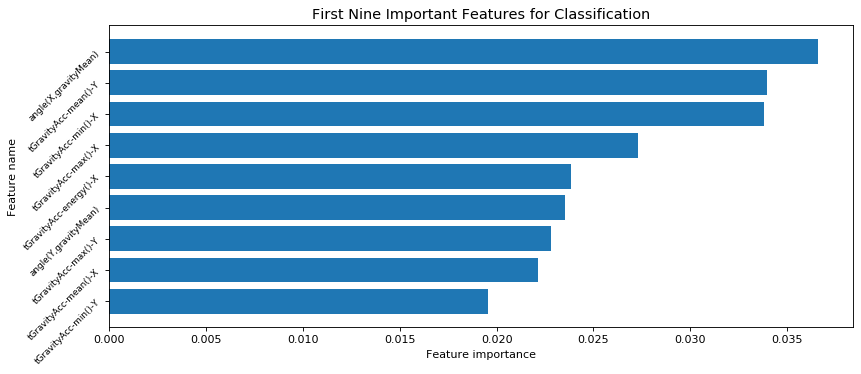

In [51]:
# visualize feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X,y)
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

fi = []
fn = []
for i in sorted(list(zip(clf.feature_importances_,X.columns)))[::-1][:9]:
    fi.append(i[0])
    fn.append(i[1])
%matplotlib inline
plt.figure(figsize=(12,5),dpi=80)
plt.barh(range(len(fn)), fi[::-1])
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(fn)), fn[::-1],fontsize=8,rotation=45)
plt.title('First Nine Important Features for Classification', fontsize = 13)
fig = plt.gcf()
fig.savefig('feature_importance.pdf')

### 3. Model Selection

#### 3.1 Dummy Classifier (Baseline Model 1)

In [31]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Dummy Classifier
    model = DummyClassifier(strategy="most_frequent")
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.19137664230527157


#### 3.2 KNN Classifier (Baseline Model 2)

In [34]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # KNN Classifier
    model = KNeighborsClassifier()
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.8879355150253743


#### 3.3 Logistic Regression

In [35]:
valid_scores = []
parameters = {'C': [0.01, 0.1, 1, 10]}
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Logistic Regression
    model = LogisticRegression()
    grid_cv = GridSearchCV(model, parameters, cv = 5)
    grid_cv.fit(X_train_folds, y_train_folds)
    best_model = LogisticRegression(**grid_cv.best_params_)
    best_model.fit(X_train_folds, y_train_folds)
    valid_scores.append(best_model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.9276813839912916


#### 3.4 Linear SVC

In [40]:
valid_scores = []
parameters = {'C': [0.01, 0.1, 1, 10]}
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Linear SVC
    model = LinearSVC()
    grid_cv = GridSearchCV(model, parameters, cv = 5)
    grid_cv.fit(X_train_folds, y_train_folds)
    best_model = LinearSVC(**grid_cv.best_params_)
    best_model.fit(X_train_folds, y_train_folds)
    valid_scores.append(best_model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.924417772487302


#### 3.5 RBF-Kernel SVM

In [48]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # RBF-Kernel Classifier
    model = SVC(kernel='rbf', C = 10, gamma = 0.01)
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.9328341408380343


#### 3.6 GuassianNB

In [42]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Guassian Naive Bayes
    model = GaussianNB()
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.8157261819730846


#### 3.7 Bagging Models - Random Forest

In [43]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Random Forest
    model = RandomForestClassifier(n_estimators = 100, random_state = 0)
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.9077858888419981


#### 3.8 Boosting Models - SGD

In [46]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # Gradient boosting
    model = GradientBoostingClassifier(random_state=0)
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.9099771081310124


#### 3.9 Neural Network - MLP

In [47]:
valid_scores = []
kf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = False)
for train_index, valid_index in kf.split(X_selected,y):
    (X_train_folds, y_train_folds, X_valid_fold, y_valid_fold) = (X_selected[train_index], y[train_index], X_selected[valid_index], y[valid_index])
    # MLP
    model = MLPClassifier(hidden_layer_sizes = 100,solver='lbfgs',
                         random_state = 0,activation = 'relu')
    model.fit(X_train_folds,y_train_folds)
    valid_scores.append(model.score(X_valid_fold, y_valid_fold))
    
mean_valid_score = np.mean(valid_scores)   
print("(selected feature)Validation accuracy: {}".format(mean_valid_score))

(selected feature)Validation accuracy: 0.9171929323600784


From the above results, we can see that RBF-Kernel SVM get the highest mean accuracy score of 0.9328 on validation set. So, we further tune the parameters of this model on the whole original training set by cross-validation.

#### Tune Parameters of RBF-Kernel SVM

In [53]:
X_train_selected, X_valid_selected, y_train, y_valid = train_test_split(X_selected,y,random_state = 0)
parameters = {'C': [0.01, 0.1, 1, 10],'gamma': [0.01, 0.1, 1, 10]}
model = SVC(kernel='rbf')
grid_cv = GridSearchCV(model, parameters, cv = 5)
grid_cv.fit(X_train_selected, y_train)

print("Best parameters: ", grid_cv.best_params_)

Best parameters:  {'C': 10, 'gamma': 0.1}


Therefore, we get our final model as RBF-Kernel SVM, with C = 10 and gamma = 0.1.

### 4. Evaluation and Analysis

#### 4.1 Calculate Accuracy on test set

In [55]:
# Final model:
final_model = SVC(kernel='rbf',C = 10, gamma = 0.1)
final_model.fit(X_selected,y)
y_final_pred = final_model.predict(X_test_selected)
test_score_final = final_model.score(X_test_selected,y_test)
print("Test accuracy: {}".format(test_score_final))

Test accuracy: 0.9524940617577197


In [56]:
# Benchmark model 1 - dummy classifier:
bench_model1 = DummyClassifier(strategy="most_frequent")
bench_model1.fit(X_selected,y)
print("Test accuracy: {}".format(bench_model1.score(X_test_selected,y_test)))

Test accuracy: 0.18221920597217509


In [57]:
# Benchmark model 2 - knn classifier:
bench_model2 = KNeighborsClassifier()
bench_model2.fit(X_selected,y)
y_bench_pred = bench_model2.predict(X_test_selected)
test_score_bench = bench_model2.score(X_test_selected,y_test)
print("Test accuracy: {}".format(test_score_bench))

Test accuracy: 0.9060061079063454


#### 4.2 Calculate Confusion Matrix on test set

In [59]:
# Final model:
cf_mat = confusion_matrix(y_test, y_final_pred, labels = ['WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','WALKING','SITTING',
                                           'STANDING','LAYING'])
 
df = pd.DataFrame(cf_mat)
df = df.rename(index = {0:'WALKING_UPSTAIRS',1:'WALKING_DOWNSTAIRS',2:'WALKING',3:'SITTING',4:'STANDING',5:'LAYING'},\
             columns = {0:'PRED_WALKING_UPSTAIRS',1:'PRED_WALKING_DOWNSTAIRS',2:'PRED_WALKING',3:'PRED_SITTING',4:'PRED_STANDING',5:'PRED_LAYING'})

df['Recall'] = np.diag(cf_mat)/np.sum(cf_mat,axis = 1)
df['Recall'] = df['Recall'].apply(lambda x: '%.3f%%' % (x*100))

preci = dict(zip(np.array(['PRED_WALKING_UPSTAIRS','PRED_WALKING_DOWNSTAIRS','PRED_WALKING','PRED_SITTING','PRED_STANDING','PRED_LAYING']),np.diag(cf_mat)/np.sum(cf_mat,axis = 0)))
preci = list(np.diag(cf_mat)/np.sum(cf_mat,axis = 0))
preci.append(test_score_final)
preci_row = np.array(preci)
preci_dict = dict(zip(np.array(['PRED_WALKING_UPSTAIRS','PRED_WALKING_DOWNSTAIRS','PRED_WALKING',\
                                'PRED_SITTING','PRED_STANDING','PRED_LAYING','Recall']),preci_row))
df_preci = pd.DataFrame(preci_dict,index = ['Precision'])
df_preci.loc['Precision'] = df_preci.loc['Precision'].apply(lambda x: '%.3f%%' % (x*100))

confu_mat_final = pd.concat([df,df_preci])
confu_mat_final

,PRED_WALKING_UPSTAIRS,PRED_WALKING_DOWNSTAIRS,PRED_WALKING,PRED_SITTING,PRED_STANDING,PRED_LAYING,Recall
WALKING_UPSTAIRS,454,2,15,0,0,0,96.391%
WALKING_DOWNSTAIRS,28,385,7,0,0,0,91.667%
WALKING,8,8,480,0,0,0,96.774%
SITTING,1,0,0,435,52,3,88.595%
STANDING,0,0,0,16,516,0,96.992%
LAYING,0,0,0,0,0,537,100.000%
Precision,92.464%,97.468%,95.618%,96.452%,90.845%,99.444%,95.249%


In [60]:
# Benchmark model: KNN Classifier
cf_mat = confusion_matrix(y_test, y_bench_pred, labels = ['WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','WALKING','SITTING',
                                           'STANDING','LAYING'])
 
df = pd.DataFrame(cf_mat)
df = df.rename(index = {0:'WALKING_UPSTAIRS',1:'WALKING_DOWNSTAIRS',2:'WALKING',3:'SITTING',4:'STANDING',5:'LAYING'},\
             columns = {0:'PRED_WALKING_UPSTAIRS',1:'PRED_WALKING_DOWNSTAIRS',2:'PRED_WALKING',3:'PRED_SITTING',4:'PRED_STANDING',5:'PRED_LAYING'})

df['Recall'] = np.diag(cf_mat)/np.sum(cf_mat,axis = 1)
df['Recall'] = df['Recall'].apply(lambda x: '%.3f%%' % (x*100))

preci = dict(zip(np.array(['PRED_WALKING_UPSTAIRS','PRED_WALKING_DOWNSTAIRS','PRED_WALKING','PRED_SITTING','PRED_STANDING','PRED_LAYING']),np.diag(cf_mat)/np.sum(cf_mat,axis = 0)))
preci = list(np.diag(cf_mat)/np.sum(cf_mat,axis = 0))
preci.append(test_score_bench)
preci_row = np.array(preci)
preci_dict = dict(zip(np.array(['PRED_WALKING_UPSTAIRS','PRED_WALKING_DOWNSTAIRS','PRED_WALKING',\
                                'PRED_SITTING','PRED_STANDING','PRED_LAYING','Recall']),preci_row))
df_preci = pd.DataFrame(preci_dict,index = ['Precision'])
df_preci.loc['Precision'] = df_preci.loc['Precision'].apply(lambda x: '%.3f%%' % (x*100))

confu_mat_benchmark = pd.concat([df,df_preci])
confu_mat_benchmark 

,PRED_WALKING_UPSTAIRS,PRED_WALKING_DOWNSTAIRS,PRED_WALKING,PRED_SITTING,PRED_STANDING,PRED_LAYING,Recall
WALKING_UPSTAIRS,423,17,31,0,0,0,89.809%
WALKING_DOWNSTAIRS,42,352,26,0,0,0,83.810%
WALKING,4,13,479,0,0,0,96.573%
SITTING,2,0,0,381,108,0,77.597%
STANDING,0,0,0,34,498,0,93.609%
LAYING,0,0,0,0,0,537,100.000%
Precision,89.809%,92.147%,89.366%,91.807%,82.178%,100.000%,90.601%


#### 4.3 Compare runtime on final model ( full features v.s. selected features )

In [61]:
final_model = SVC(kernel='rbf',C = 10, gamma = 0.1)
start_time = time.time()
final_model.fit(X,y)
print("(Full Features)Test accuracy: {}".format(final_model.score(X_test,y_test)))
print("(Full Features)Runtime: {}".format(time.time()-start_time))
print("----------------------------------------")
final_model = SVC(kernel='rbf',C = 10, gamma = 0.1)
start_time = time.time()
final_model.fit(X_selected,y)
print("(Selected Features)Test accuracy: {}".format(final_model.score(X_test_selected,y_test)))
print("(Selected Features)Runtime: {}".format(time.time()-start_time))

(Full Features)Test accuracy: 0.9558873430607397
(Full Features)Runtime: 22.03092670440674
----------------------------------------
(Selected Features)Test accuracy: 0.9524940617577197
(Selected Features)Runtime: 3.7815659046173096
